In [52]:
#Import Libraries
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import ast
import seaborn as sns

#Load Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

#Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [4]:
job_title = 'Data Analyst'
job_place = 'United Kingdom'
# Create new dataframe of data analyst job postings from United Kingdom
df_da_uk = df[(df['job_title_short'] == job_title) & (df['job_country'] == job_place)].copy()

In [10]:
# Extract the month number from 'job_posted_date' and store it in 'job_posted_month_no'.
# Expand rows in 'df_da_uk' for each skill in the 'job_skills' list, creating one row per skill.
df_da_uk['job_posted_month_no'] = df_da_uk['job_posted_date'].dt.month
df_explode = df_da_uk.explode('job_skills')

In [18]:
# Create a pivot table with 'job_posted_month_no' as rows and 'job_skills' as columns,
# counting occurrences of each skill per month and filling missing values with 0.
# Add a 'total' row with the sum of each skill's counts across all months and sort columns by their total counts in descending order.
# Remove the 'total' row to leave only monthly data in the pivot table.
df_pivot = df_explode.pivot_table(index='job_posted_month_no', columns='job_skills', aggfunc='size', fill_value=0)
df_pivot.loc['total'] = df_pivot.sum()
df_pivot = df_pivot[df_pivot.loc['total'].sort_values(ascending=False).index]
df_pivot = df_pivot.drop('total')

In [26]:
# Calculate the total number of job postings for each month ('job_posted_month_no').
# Convert the pivot table counts to percentages by dividing each skill count by the total job postings per month.
# Reset the index of the percentage DataFrame and create a new column for the month name ('job_posted_month').
# Convert the month number to its abbreviated name (e.g., 1 → Jan) using a datetime format.
# Set the month name as the index and remove the 'job_posted_month_no' column for cleaner presentation.
df_totals = df_da_uk.groupby('job_posted_month_no').size()
df_perc = df_pivot.div(df_totals/100, axis=0)
df_perc = df_perc.reset_index()
df_perc['job_posted_month'] = df_perc['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_perc = df_perc.set_index('job_posted_month')
df_perc = df_perc.drop(columns='job_posted_month_no')

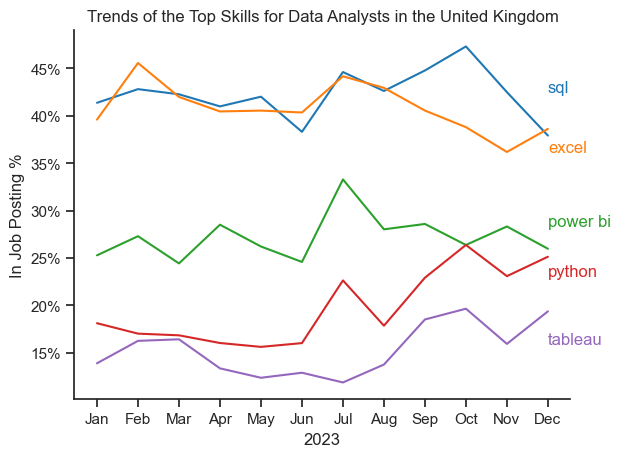

In [58]:
# Plot the trends for the top 5 skills from 'df_perc' over the months of 2023.
df_plot = df_perc.iloc[:, :5]
sns.set_theme(style='ticks')
# Use a line plot with no dashes and a 'tab10' color palette for distinct skill lines.
sns.lineplot(data=df_plot, dashes=False, palette='tab10', legend=False)
# Annotate the end of each line with the corresponding skill name for clarity.
for i in range(5):
    plt.text(11, df_plot.iloc[-2, i], df_plot.columns[i], color=sns.color_palette('tab10')[i])
sns.despine()
ax = plt.gca()
# Format the y-axis to display percentages with no decimals.
ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))
# Add a title dynamically using 'job_title' and 'job_place', and label the axes.
# Remove extra plot spines for a cleaner appearance and display the final plot.
plt.title(f'Trends of the Top Skills for {job_title}s in the {job_place}')
plt.ylabel('In Job Posting %')
plt.xlabel('2023')
plt.show()
